Iteration 1/30, Noise Variance: 2.402211475433781
Iteration 2/30, Noise Variance: 2.8327741521684024
Iteration 3/30, Noise Variance: 2.9046479966578302
Iteration 4/30, Noise Variance: 2.9364379985186475
Iteration 5/30, Noise Variance: 2.9548053815379305
Iteration 6/30, Noise Variance: 2.9660511952772532
Iteration 7/30, Noise Variance: 2.9731203981894243
Iteration 8/30, Noise Variance: 2.9776703283843196
Iteration 9/30, Noise Variance: 2.980666367190162
Iteration 10/30, Noise Variance: 2.9826810709483773
Iteration 11/30, Noise Variance: 2.98406149863866
Iteration 12/30, Noise Variance: 2.985023062258514
Iteration 13/30, Noise Variance: 2.9857025588159494
Iteration 14/30, Noise Variance: 2.9861887233964475
Iteration 15/30, Noise Variance: 2.9865402544950976
Iteration 16/30, Noise Variance: 2.986796695499095
Iteration 17/30, Noise Variance: 2.9869851406088754
Iteration 18/30, Noise Variance: 2.98712444546399
Iteration 19/30, Noise Variance: 2.9872279179987036
Iteration 20/30, Noise Varian

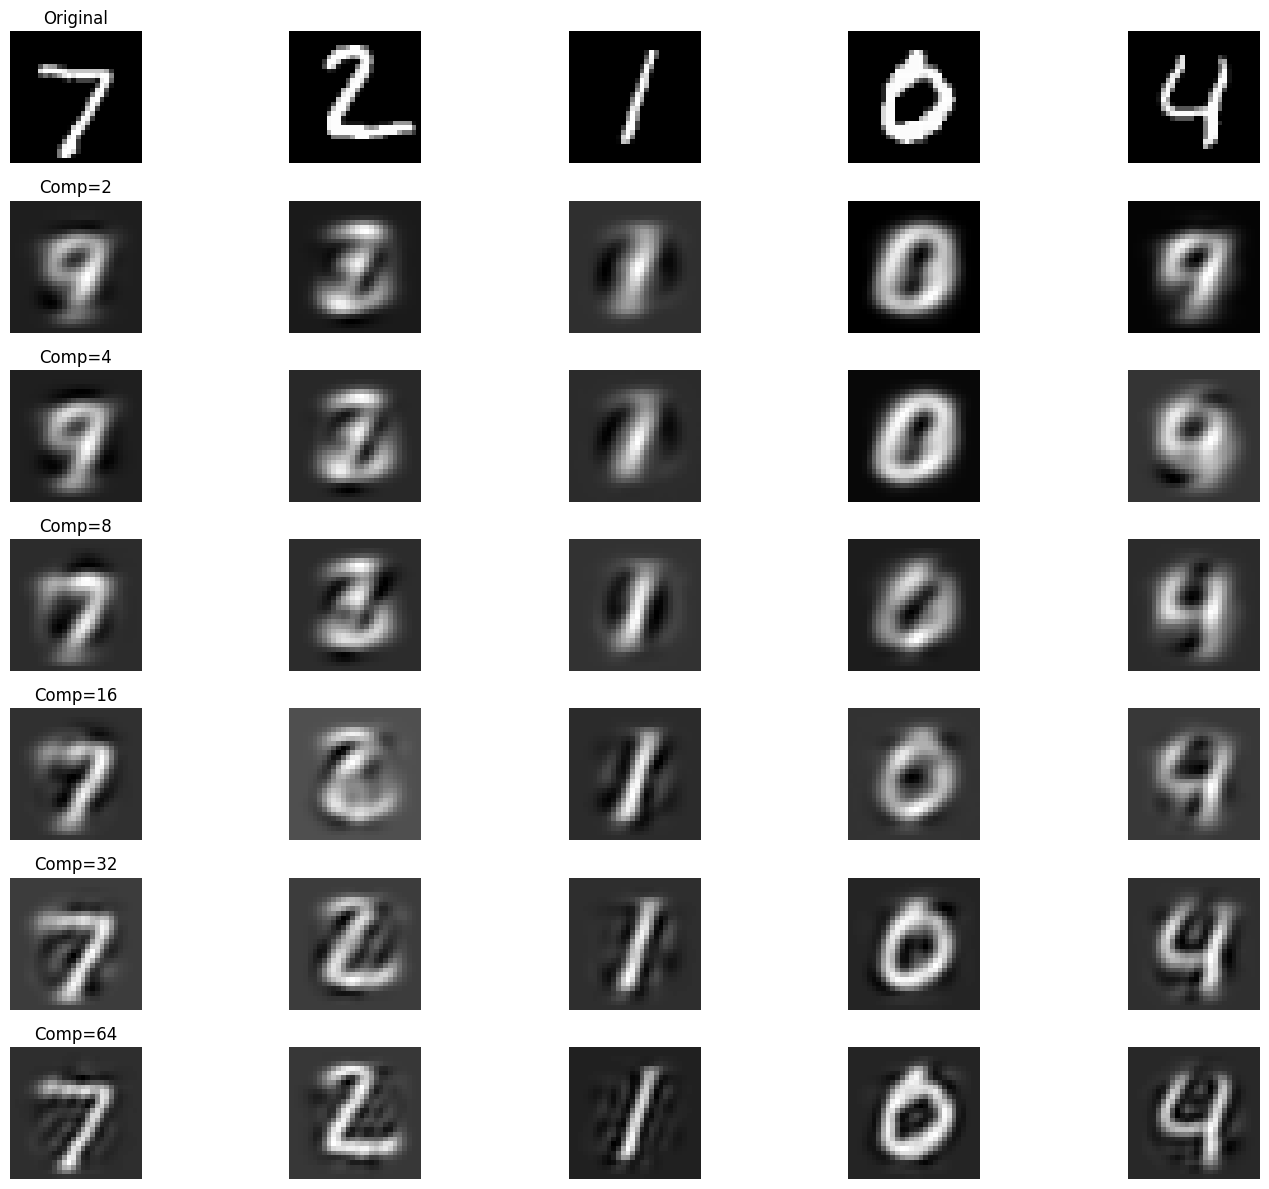

Error for 2 components: 0.055670
Error for 4 components: 0.047904
Error for 8 components: 0.037444
Error for 16 components: 0.026861
Error for 32 components: 0.016864
Error for 64 components: 0.009053


In [7]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Creating a Probabilistic PCA class which uses EM algorithm
class PPCA_EM:
    #initialisation of default value constructor
    def __init__(self, components=2, noise_variance=1.0, iterations=20):
        self.components = components #no of principle componenents
        self.noise_variance = noise_variance
        self.iterations = iterations
        self.is_initialized = False

    #fitting the model using em algorithm
    def apply_fit(self, dataset):
        self.features = dataset.shape[1]
        self.samples = dataset.shape[0]
        self.mean = np.mean(dataset, axis=0)
        self.is_initialized = True
        self.run_em_algorithm(dataset)

    #reducing the dimestions
    def encode(self, dataset):
        #transformation matrix for reducing dimensions
        matrix = np.dot(self.weights.T, self.weights) + self.noise_variance * np.eye(self.components)
        matrix_inverse = np.linalg.inv(matrix)
        encoded_data = np.dot(matrix_inverse, np.dot(self.weights.T, (dataset - self.mean).T)).T
        return encoded_data

    #back to original dimension
    def decode(self, encoded_dataset):
        return np.dot(encoded_dataset, self.weights.T) + self.mean

    #em algorithm to determine the weights
    def run_em_algorithm(self, dataset):
        #randomly initialising the weights
        self.weights = np.random.rand(self.features, self.components)
        for iteration in range(self.iterations):
            #computing encoded data and its covariance(E-Step)
            matrix = np.dot(self.weights.T, self.weights) + self.noise_variance * np.eye(self.components)
            matrix_inverse = np.linalg.inv(matrix)
            encoded_data = np.dot(matrix_inverse, np.dot(self.weights.T, (dataset - self.mean).T)).T
            encoded_covariance = self.noise_variance * matrix_inverse + np.dot(encoded_data.T, encoded_data)

            # M-step: updating weights and calculating noise variance
            self.weights = np.dot(np.dot((dataset - self.mean).T, encoded_data), np.linalg.inv(encoded_covariance))
            variance_terms = np.mean(np.square(dataset - self.mean)) - 2 * np.trace(np.dot(encoded_data, self.weights.T)) / self.samples + np.trace(np.dot(encoded_covariance, np.dot(self.weights.T, self.weights))) / self.samples
            self.noise_variance = np.sqrt(variance_terms)
            print(f'Iteration {iteration + 1}/{self.iterations}, Noise Variance: {self.noise_variance}')

# Data preprocessing
(train_data, _), (test_data, _) = mnist.load_data()

#reshaping and normalising
train_data = train_data.reshape((train_data.shape[0], -1)).astype('float32') / 255
test_data = test_data.reshape((test_data.shape[0], -1)).astype('float32') / 255

# Initialising the model
target_dimensions = [2, 4, 8, 16, 32, 64]
model_storage = {}
for dimension in target_dimensions:
    reducer = PPCA_EM(components=dimension, noise_variance=1.0, iterations=20)
    reducer.apply_fit(train_data)
    model_storage[dimension] = reducer

# Visualizing the images
image_count = 5
chosen_images = test_data[:image_count]
fig, axes = plt.subplots(len(target_dimensions) + 1, image_count, figsize=(15, 12))

for i in range(image_count):
    axes[0, i].imshow(chosen_images[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Original")

for index, dimension in enumerate(target_dimensions):
    reconstruction = model_storage[dimension].decode(model_storage[dimension].encode(chosen_images))
    for j in range(image_count):
        axes[index + 1, j].imshow(reconstruction[j].reshape(28, 28), cmap='gray')
        axes[index + 1, j].axis('off')
        if j == 0:
            axes[index + 1, j].set_title(f"Comp={dimension}")

plt.tight_layout()
plt.show()

# MSE calculation
error_metrics = {}
for dimension in target_dimensions:
    reconstructed_set = model_storage[dimension].decode(model_storage[dimension].encode(test_data))
    mse = np.mean((test_data - reconstructed_set) ** 2)
    error_metrics[dimension] = mse
    print(f'Error for {dimension} components: {mse:.6f}')
